<a href="https://colab.research.google.com/github/g95wang/pre-training/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

tf.compat.v1.enable_eager_execution()

In [2]:
BATCH_SIZE = 32
EPOCHS = 100
VALIDATION_SPLIT = 0.2
THRESHOLD = 0.95

In [3]:
def validation_split(x_train, y_train):
  mask = np.random.rand(x_train.shape[0]) < VALIDATION_SPLIT
  x_validation, y_validation = x_train[mask], y_train[mask]
  x_train, y_train = x_train[~mask], y_train[~mask]
  return (x_train, y_train), (x_validation, y_validation)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

# Simulate unlabeled dataset
labeled_index = np.random.choice(x_train.shape[0], int(x_train.shape[0] * 0.1), replace=False)
labeled_mask = np.zeros(len(x_train), dtype=bool)
labeled_mask[labeled_index] = 1
labeled_x_train, labeled_y_train = x_train[labeled_mask], y_train[labeled_mask]
unlabeled_x_train, unlabeled_y_train = x_train[~labeled_mask], y_train[~labeled_mask]

print("Number of labeled training examples:", len(labeled_x_train))
print("Number of unlabeled training examples:", len(unlabeled_x_train))

Number of original training examples: 60000
Number of original test examples: 10000
Number of labeled training examples: 6000
Number of unlabeled training examples: 54000


In [5]:
(pre_x_train, pre_y_train), (pre_x_validation, pre_y_validation) = validation_split(x_train, y_train)
(x_train, y_train), (x_validation, y_validation) = validation_split(x_train, y_train)

In [6]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
      # layers.MaxPooling2D((2, 2)),
      layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2)])
      # layers.MaxPooling2D((2, 2))])

    self.decoder = tf.keras.Sequential([
      # layers.UpSampling2D((2,2)),        
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      # layers.UpSampling2D((2, 2)),        
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.build((32, 28, 28, 1))
autoencoder.encoder.summary()
autoencoder.decoder.summary()
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          9248      
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (32, 14, 14, 32)          9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (32, 28, 28, 32)          9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 28, 28, 1)           289       
Total params: 18,785
Trainable p

In [7]:
model = tf.keras.models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2', input_shape=(28, 28, 1)),
  # layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(32,activation='relu', kernel_regularizer='l2'),
  layers.Dense(10,activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

model.save_weights("./init")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                147488    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 157,386
Trainable params: 157,386
Non-trainable params: 0
________________________________________________

In [8]:
model_wo_pretrain = tf.keras.models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2', input_shape=(28, 28, 1)),
  # layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(32,activation='relu', kernel_regularizer='l2'),
  layers.Dense(10,activation='softmax')
])

model_wo_pretrain.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_wo_pretrain.summary()

model_wo_pretrain.load_weights("./init")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                147488    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 157,386
Trainable params: 157,386
Non-trainable params: 0
________________________________________________

In [9]:
best_loss = 1000
for epoch in range(3):
  history = autoencoder.fit(pre_x_train, pre_x_train, validation_data=(pre_x_validation, pre_x_validation))
  loss = history.history['val_loss'][0]
  if loss < best_loss:
    autoencoder.save_weights("./checkpoint")
    print("Saving checkpoint")
    best_loss = loss
autoencoder.load_weights("./checkpoint")
supervised_loss = autoencoder.evaluate(x_test, x_test)

1504/1504 [==============================] - 7s 4ms/step - loss: 0.0276 - val_loss: 9.0861e-04
Saving checkpoint
1504/1504 [==============================] - 5s 3ms/step - loss: 6.6452e-04 - val_loss: 5.1416e-04
Saving checkpoint
1504/1504 [==============================] - 5s 3ms/step - loss: 4.3417e-04 - val_loss: 3.7115e-04
Saving checkpoint
313/313 [==============================] - 1s 2ms/step - loss: 3.7146e-04


In [10]:
# sess = tf.compat.v1.Session()
weights = model.weights
weights[0] = autoencoder.weights[0]
weights[1] = autoencoder.weights[1]

for i in range(len(weights)):
  weights[i] = weights[i].numpy()

model.set_weights(weights)

In [11]:
best_loss = 1000
train_accuracy, train_loss, validation_accuracy, validation_loss = [], [], [], []
for epoch in range(EPOCHS):
  history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), steps_per_epoch=100)
  train_accuracy.append(history.history['sparse_categorical_accuracy'][0])
  train_loss.append(history.history['loss'][0])
  validation_accuracy.append(history.history['val_sparse_categorical_accuracy'][0])
  validation_loss.append(history.history['val_loss'][0])
  loss = history.history['val_loss'][0]
  if loss < best_loss:
    model.save_weights("./checkpoint")
    print("Saving checkpoint")
    best_loss = loss
model.load_weights("./checkpoint")
supervised_loss = model.evaluate(x_test, y_test)

100/100 [==============================] - 3s 22ms/step - loss: 1.6963 - sparse_categorical_accuracy: 0.6658 - val_loss: 0.5892 - val_sparse_categorical_accuracy: 0.9254
Saving checkpoint
100/100 [==============================] - 2s 20ms/step - loss: 0.4812 - sparse_categorical_accuracy: 0.9397 - val_loss: 0.4065 - val_sparse_categorical_accuracy: 0.9508
Saving checkpoint
100/100 [==============================] - 2s 19ms/step - loss: 0.3740 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.3457 - val_sparse_categorical_accuracy: 0.9558
Saving checkpoint
100/100 [==============================] - 2s 19ms/step - loss: 0.3216 - sparse_categorical_accuracy: 0.9613 - val_loss: 0.3143 - val_sparse_categorical_accuracy: 0.9617
Saving checkpoint
100/100 [==============================] - 2s 19ms/step - loss: 0.2989 - sparse_categorical_accuracy: 0.9628 - val_loss: 0.2974 - val_sparse_categorical_accuracy: 0.9613
Saving checkpoint
100/100 [==============================] - 2s 19ms/step - lo

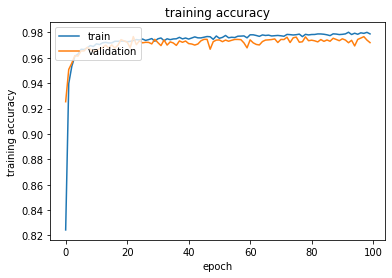

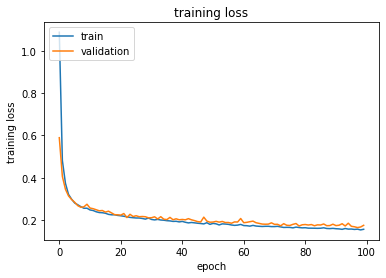

[0.1537356674671173, 0.9811000227928162]


In [12]:
# Plot accuracy
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['train', "validation"], loc='upper left')
plt.show()

# Plot loss
plt.plot(train_loss)
plt.plot(validation_loss)
plt.title('training loss')
plt.ylabel('training loss')
plt.xlabel('epoch')
plt.legend(['train', "validation"], loc='upper left')
plt.show()

print(supervised_loss)

In [13]:
best_loss = 1000
train_accuracy_wo_pretrain, train_loss_wo_pretrain, validation_accuracy_wo_pretrain, validation_loss_wo_pretrain = [], [], [], []
for epoch in range(EPOCHS):
  history = model_wo_pretrain.fit(x_train, y_train, validation_data=(x_validation, y_validation), steps_per_epoch=10)
  train_accuracy_wo_pretrain.append(history.history['sparse_categorical_accuracy'][0])
  train_loss_wo_pretrain.append(history.history['loss'][0])
  validation_accuracy_wo_pretrain.append(history.history['val_sparse_categorical_accuracy'][0])
  validation_loss_wo_pretrain.append(history.history['val_loss'][0])
  loss = history.history['val_loss'][0]
  if loss < best_loss:
    model_wo_pretrain.save_weights("./checkpoint")
    print("Saving checkpoint")
    best_loss = loss
model_wo_pretrain.load_weights("./checkpoint")
supervised_loss_wo_pretrain = model_wo_pretrain.evaluate(x_test, y_test)

10/10 [==============================] - 4s 280ms/step - loss: 3.0383 - sparse_categorical_accuracy: 0.2248 - val_loss: 2.1006 - val_sparse_categorical_accuracy: 0.6134
Saving checkpoint
10/10 [==============================] - 2s 183ms/step - loss: 1.5544 - sparse_categorical_accuracy: 0.7555 - val_loss: 1.1106 - val_sparse_categorical_accuracy: 0.8319
Saving checkpoint
10/10 [==============================] - 2s 182ms/step - loss: 0.9840 - sparse_categorical_accuracy: 0.8660 - val_loss: 0.8812 - val_sparse_categorical_accuracy: 0.8869
Saving checkpoint
10/10 [==============================] - 2s 185ms/step - loss: 0.8108 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.7516 - val_sparse_categorical_accuracy: 0.9013
Saving checkpoint
10/10 [==============================] - 2s 192ms/step - loss: 0.6989 - sparse_categorical_accuracy: 0.9124 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.9136
Saving checkpoint
10/10 [==============================] - 2s 186ms/step - loss: 0.

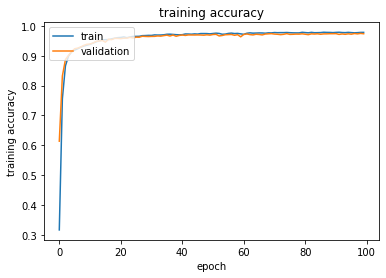

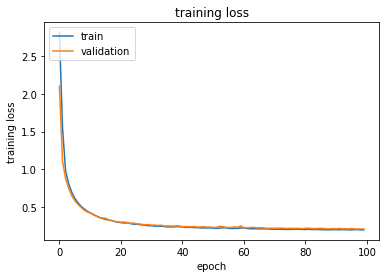

[0.19682106375694275, 0.9779000282287598]


In [14]:
# Plot accuracy
plt.plot(train_accuracy_wo_pretrain)
plt.plot(validation_accuracy_wo_pretrain)
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['train', "validation"], loc='upper left')
plt.show()

# Plot loss
plt.plot(train_loss_wo_pretrain)
plt.plot(validation_loss_wo_pretrain)
plt.title('training loss')
plt.ylabel('training loss')
plt.xlabel('epoch')
plt.legend(['train', "validation"], loc='upper left')
plt.show()

print(supervised_loss_wo_pretrain)

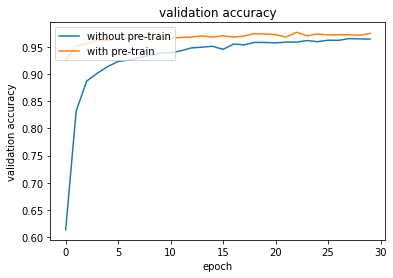

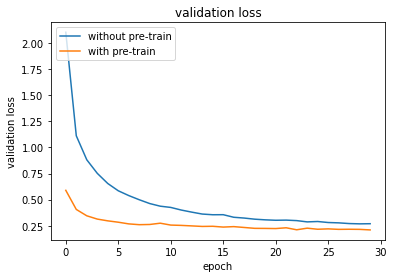

Test loss with pre-training:  0.1537356674671173
Test accuracy with pre-training:  0.9811000227928162
Test loss without pre-training:  0.19682106375694275
Test accuracy without pre-training:  0.9779000282287598


In [18]:
# Plot accuracy
plt.plot(validation_accuracy_wo_pretrain[:30])
plt.plot(validation_accuracy[:30])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['without pre-train', "with pre-train"], loc='upper left')
plt.show()

# Plot loss
plt.plot(validation_loss_wo_pretrain[:30])
plt.plot(validation_loss[:30])
plt.title('validation loss')
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(['without pre-train', "with pre-train"], loc='upper left')
plt.show()

print("Test loss with pre-training: ", supervised_loss[0])
print("Test accuracy with pre-training: ", supervised_loss[1])
print("Test loss without pre-training: ", supervised_loss_wo_pretrain[0])
print("Test accuracy without pre-training: ", supervised_loss_wo_pretrain[1])